In [ ]:
faire graphe sur réal, acteurs...
autres modèles de graphes - à chercher 

In [ ]:
#script utilisant Networkx pour détecter des communautés entre movies.

#Pb : trop de données, méthode de Girvan Newman trop lente, pas fait
#Pb 2 : approche agglomérative non plus, fonction nx.all_pairs... trop lente

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
from community import community_louvain
from networkx.algorithms.community.quality import performance
from networkx.algorithms.community.quality import coverage
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community import modularity_max
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

In [1]:
ratings=pd.read_csv('../../../dataset/ml-20m/ratings.csv')
df_ref=pd.read_csv('../../new_dataset/correspondances_Id_movie')
df=pd.read_csv('../../new_dataset/movie_df.csv')

list_movieId=pd.read_csv('../reduced_list_movieId.txt', header=None, names=["movieId_ref"])
list_userId=pd.read_csv('../reduced_list_userId.txt', header=None, names=["userId"])

In [2]:
#Nettoyage de ratings

ratings.index=ratings.movieId
df_ref.index=df_ref.movieId
ratings=ratings.join(df_ref.movieId_ref)
ratings=ratings.drop(["timestamp", "movieId"], axis=1)
ratings=ratings.dropna(subset=["movieId_ref"])
print(len(ratings.movieId_ref.unique()))
ratings.movieId_ref=ratings.movieId_ref.astype(int)

23608


In [3]:
#Pour le moment, données lourdes et beaucoup d'essais -> on réduit données
#Pour avoir 1/5 des users et 1/5 des films
#On a donc 22812 users et 3220 movies

liste1=list(list_movieId.movieId_ref)
liste2=list(list_userId.userId)

#Réduction des données avec les movies set Id sélectionnés dans fichier reduction_Dataset
ratings=ratings[(ratings.movieId_ref.isin(liste1))]
ratings=ratings[(ratings.userId.isin(liste2))]
print(ratings.shape)
print(len(ratings.userId.unique()))
print(len(ratings.movieId_ref.unique()))

#Renumérotation des movieId et user Id de manière continue
ratings_user=ratings.groupby("userId").count()
ratings_user["userId_red"]=np.arange(1,22813)
ratings=ratings.join(ratings_user.userId_red, on="userId")
ratings.head(40)

ratings_movie=ratings.groupby("movieId_ref").count()
ratings_movie["movieId_red"]=np.arange(1,3221)
ratings=ratings.join(ratings_movie.movieId_red, on="movieId_ref")
ratings.head(40)

ratings=ratings.sort_values(by='userId_red')
ratings=ratings.drop(["movieId_ref", "userId"], axis=1)

(567692, 3)
22812
3220


In [4]:
ratings.describe()
ratings.head()

,rating,userId_red,movieId_red
count,567692.000000,567692.000000,567692.000000
mean,3.499027,11405.873098,660.028549
std,1.054596,6590.331316,672.072800
min,0.500000,1.000000,1.000000
25%,3.000000,5694.000000,185.000000
50%,3.500000,11329.000000,412.000000
75%,4.000000,17167.000000,900.000000
max,5.000000,22812.000000,3220.000000


In [37]:
#Création d'un set contenant tous les edges de films
#(on définit une arête entre 2 films s'ils ont été notés au moins 1 fois par le même user)
#(à voir pour rajouter poids -> 1/(différence de note) entre les films ?)

number_user=len(ratings.userId_red.unique())
set_edges=set()
for k in range(1,number_user):
    group=ratings[ratings.userId_red==k]
    set_m=list(group.movieId_red)
    for i in range(len(set_m)-1):
        for j in range(i+1,len(set_m)):
            set_edges.add((set_m[i],set_m[j]))
print(len(set_edges))


  0%|          | 66/22811 [00:00<00:34, 658.52it/s]


22812


100%|██████████| 22811/22811 [00:44<00:00, 516.87it/s]IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



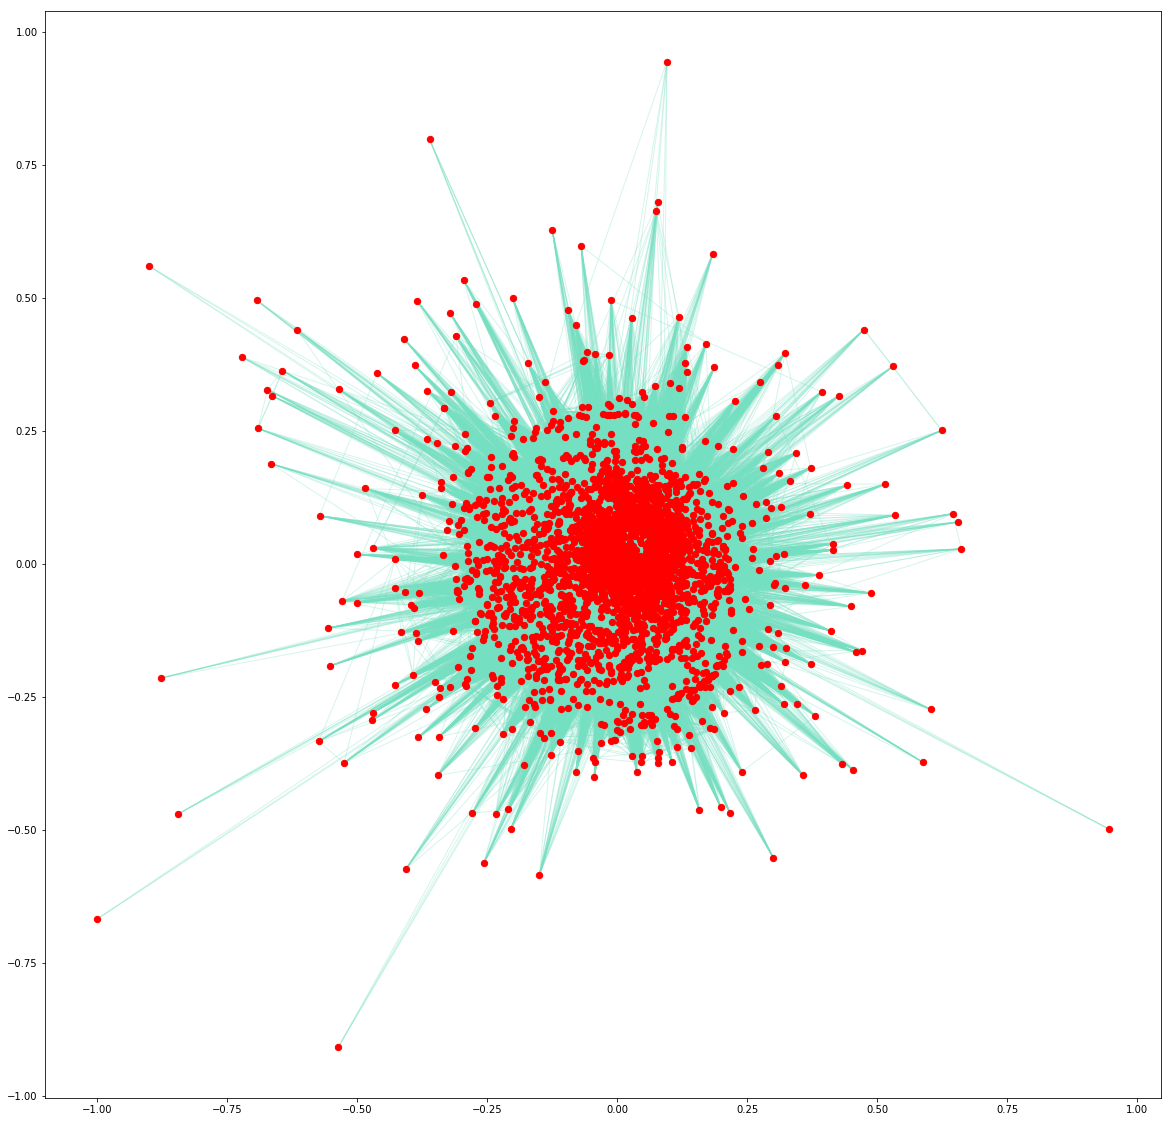

In [40]:
H=nx.Graph()
H.add_nodes_from(ratings.movieId_red)
H.add_edges_from(set_edges)

pos=nx.fruchterman_reingold_layout(H)
plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(H,pos, node_size=30)
nx.draw_networkx_edges(H, pos, edge_color = "#75DFC1", alpha = 0.3)
plt.show()

# Méthode de Louvain
Détection de communauté

In [41]:
# Détection de communautés - méthode de louvain
best_part=community_louvain.best_partition(H)

#Calculer le nombre de communautés trouvées par le partitionnement de Louvain
maximum=0
for k in best_part.values():
    if k>maximum:
        maximum=k
print(maximum)
# résultat :4 clusters

#Créer une liste de numéros de clusters matchant liste de nodes pour créer un graphe avec clusters de différentes couleurs
node_cluster=[]
for k in best_part.keys():
    node_cluster.append(best_part[k])

{394: 0, 96: 0, 341: 1, 556: 1, 8: 2, 15: 0, 559: 1, 681: 1, 295: 0, 339: 1, 682: 1, 66: 0, 220: 0, 587: 0, 185: 0, 489: 1, 429: 0, 365: 0, 537: 0, 201: 0, 611: 1, 694: 1, 417: 0, 387: 1, 225: 0, 154: 0, 367: 1, 533: 2, 532: 0, 400: 1, 128: 0, 350: 0, 352: 0, 663: 2, 545: 1, 620: 1, 399: 3, 328: 0, 462: 1, 412: 0, 598: 1, 395: 2, 897: 0, 752: 1, 755: 1, 212: 0, 287: 0, 458: 0, 726: 1, 184: 0, 3: 0, 84: 0, 78: 1, 97: 0, 65: 0, 44: 1, 452: 0, 45: 0, 1231: 0, 325: 0, 207: 0, 77: 1, 210: 0, 177: 0, 574: 1, 204: 0, 5: 1, 513: 1, 292: 1, 249: 1, 281: 1, 181: 0, 206: 0, 60: 1, 285: 1, 57: 1, 126: 1, 326: 1, 439: 1, 163: 1, 218: 0, 288: 1, 514: 0, 362: 1, 231: 1, 209: 0, 27: 1, 198: 0, 266: 1, 318: 1, 337: 0, 517: 1, 211: 0, 348: 0, 388: 2, 416: 3, 528: 1, 494: 3, 617: 0, 612: 0, 172: 2, 68: 1, 251: 1, 122: 0, 440: 1, 170: 1, 557: 1, 666: 1, 233: 0, 378: 1, 245: 3, 275: 2, 277: 3, 241: 1, 478: 1, 293: 0, 305: 2, 190: 1, 592: 0, 674: 0, 477: 0, 636: 3, 311: 0, 91: 1, 191: 1, 130: 0, 346: 1, 340

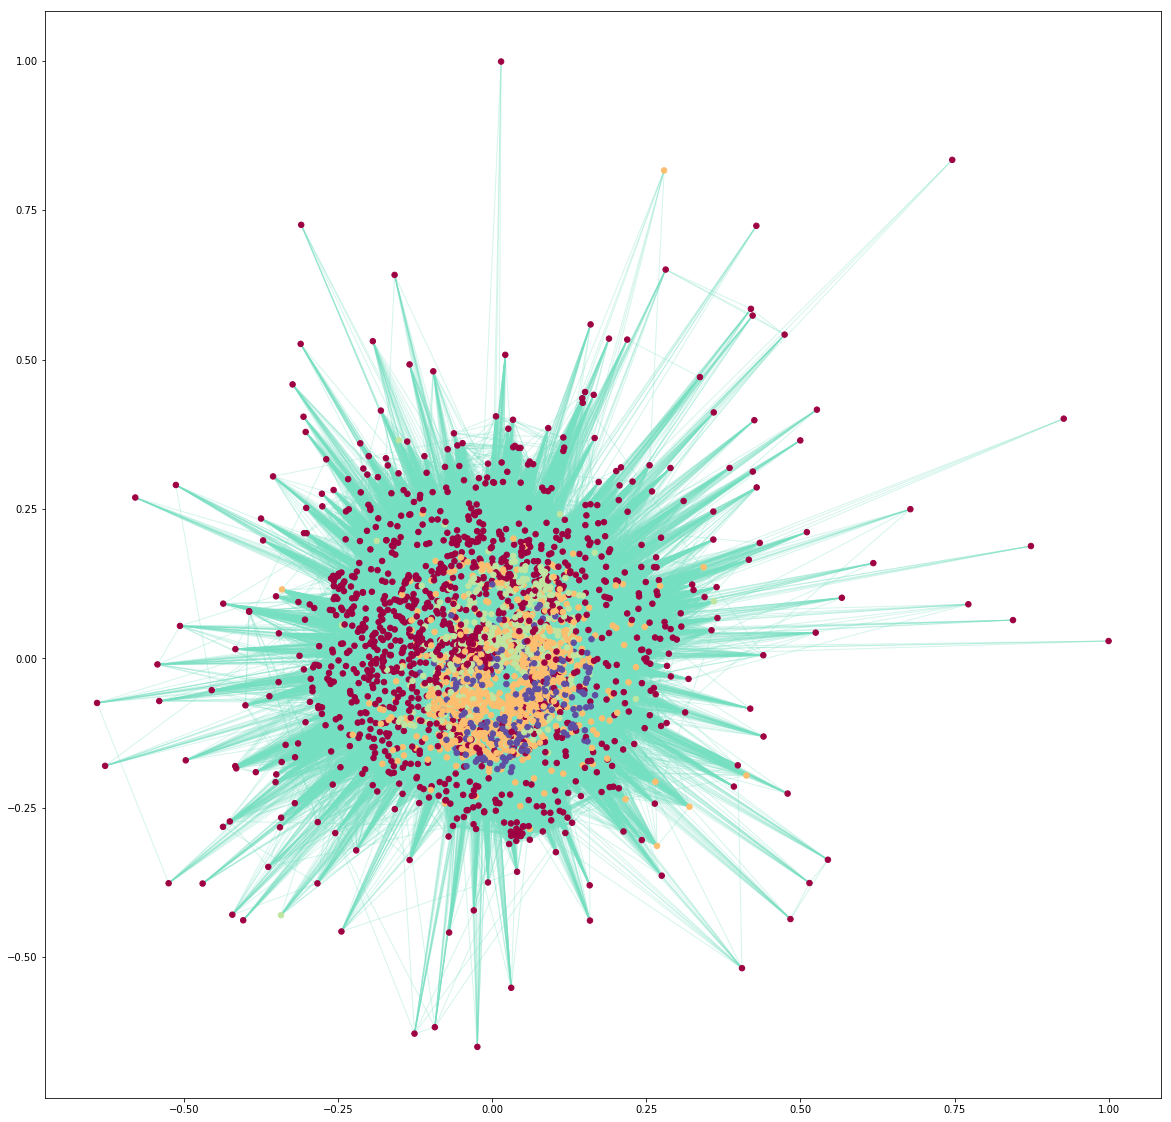

In [43]:
#Graphe des clusters de movies - méthode de Louvain

plt.figure(figsize=(20,20))
pos=nx.fruchterman_reingold_layout(H)
nx.draw_networkx_nodes(H,pos, node_color=node_cluster, node_size=30, cmap="RdBu_r")
nx.draw_networkx_edges(H,pos, edge_color = "gray", alpha = 0.3)
plt.show()

In [44]:
#Evaluation méthode de Louvain

#Modification de partition sous forme de séquence de set (chaque set est une communauté)
l_sequence=[]
for k in range(4):
    s=set([])
    for cle in best_part.keys():
        if best_part[cle]==k:
            s.add(cle)
    l_sequence.append(s)  
    
# Calcul de la performance
print(performance(H,l_sequence))
#performance 0.58

#Calcul de coverage
print(coverage(H,l_sequence))
#coverage 0.40

0.5835711487885401


## Girvan_Newman
Détection de communauté

In [26]:
#Calcul des différentes partitions
communities_generator=girvan_newman(H)

#Trouver la meilleure partition parmis toutes celles émises
#Evaluer sa performance
scores=[]
best_score=0
for partition in communities_generator:
    acc_score=performance(H,partition)
    scores.append(acc_scores)
    if acc_score>best_score:
        best_score=acc_score
        best_part=partition
print(best_score)

#Evaluation coverage de la meilleur partition
print(coverage(H,best_part))

KeyboardInterrupt: 

In [ ]:
#Création d'une liste de cluster matchant la liste des nodes pour créer un graphe avec clusters de différentes couleurs

dico={}
k=0
for element in best_part:
    element=list(element)
    for cle in element:
        dico[cle]=k
    k+=1
liste_cluster=[]
pos=nx.fruchterman_reingold_layout(H)
for cle1 in pos.keys():
    for cle2 in dico.keys():
        if cle1==cle2:
            liste_cluster.append(dico[cle2])

#Graphe des clusters de movie - méthode de Girvan Newman

plt.figure(figsize=(20,20))
nx.draw_networkx_nodes(H,pos, node_color=liste_cluster, cmap=plt.cm.Spectral)
nx.draw_networkx_edges(H,pos, edge_color="#75DFC1")
nx.draw_networkx_labels(H,pos)
plt.show()


## Approche agglomérative
Matrice d adjacence + CAH

In [56]:
#Création de la matrice d'adjacence et matrice distances mini entre tous les noeuds du graphe (matrice de similarité) 

path_length=dict(nx.all_pairs_shortest_path_length(H))
nodes=H.number_of_nodes
distances=np.zeros((nodes,nodes))
for i in tqdm(path_length.keys()):
    for j in path_length.keys():
        distances[i,j]=path_length[i][j]

KeyboardInterrupt: 

In [ ]:
#CAH et dendrogram

hclust=linkage(distances,method='ward')
dendrogram(hclust)

## Méthode de Clauset Newman Moore
based on maximising modularity

In [48]:
partition=modularity_max.greedy_modularity_communities(H)
len(partition)

In [49]:
#Evaluation du modèle
print(performance(H,partition))
#performance 0.57
print(coverage(H,partition))
#coverage 0.56

0.5760781771276524
0.5589901907665777



100%|██████████| 3221/3221 [00:00<00:00, 692955.13it/s]

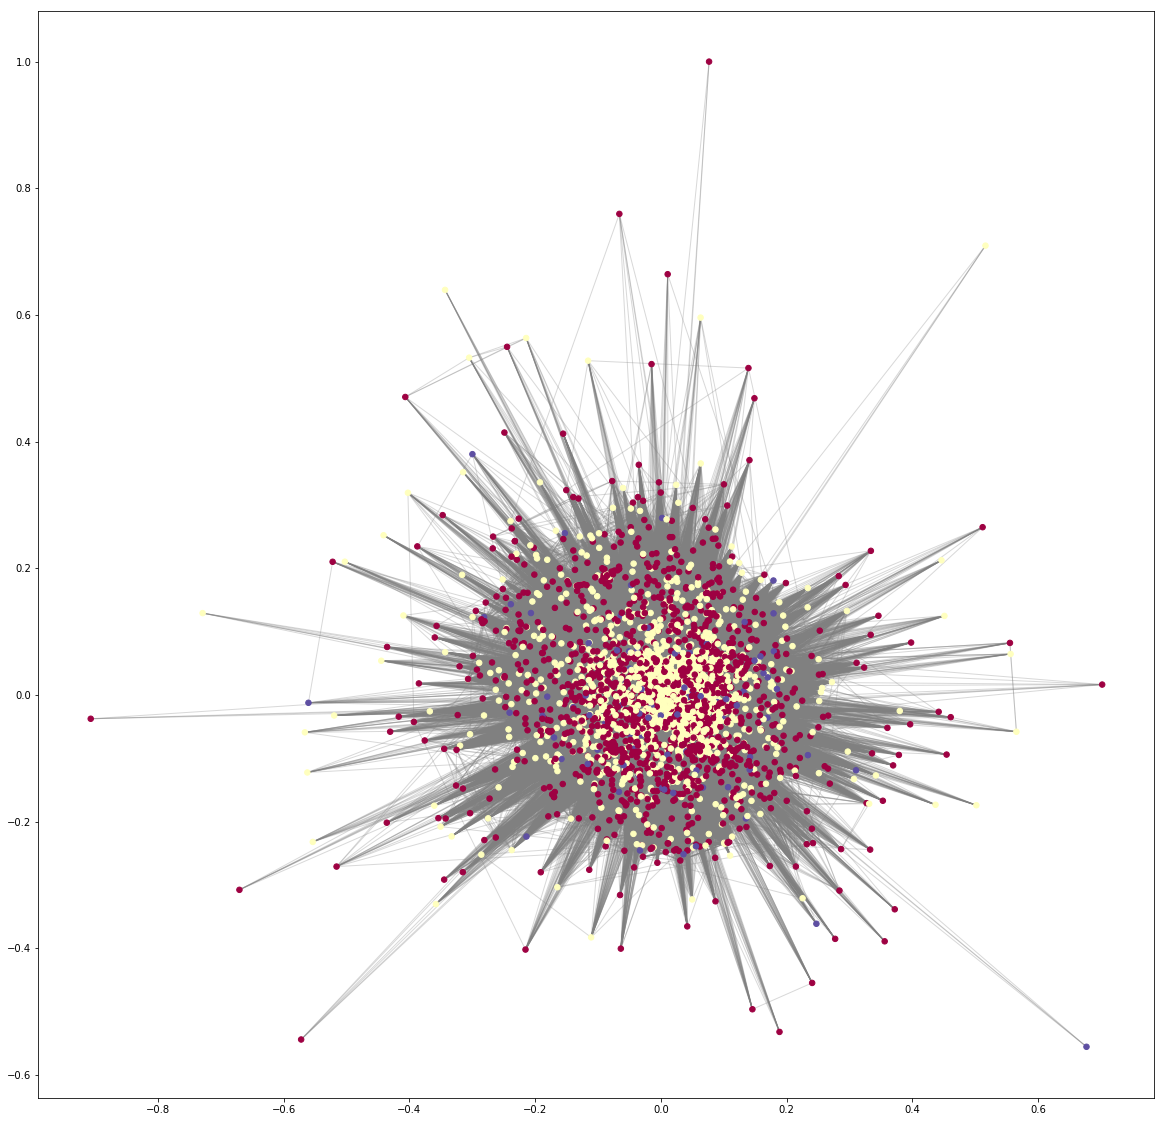

In [53]:
#Affichage de la partition:

node_cluster=[]
for i in range(3221):
    k=0
    while k <= len(partition)-1:
        element=partition[k]
        if i in element:
            node_cluster.append(k)
            break
        k+=1

#Graphe de clusters  de movies - méthode de Clauset Newman Moore        
plt.figure(figsize=(20,20))
pos=nx.fruchterman_reingold_layout(H)
nx.draw_networkx_nodes(H,pos, node_color=node_cluster, node_size=30, cmap=plt.cm.Spectral)
nx.draw_networkx_edges(H,pos, edge_color = "gray", alpha = 0.3)
plt.show()